In [453]:
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error

In [421]:
df = pd.read_csv('./data/gurgaon_properties_post_feature_selection_v2.csv')
df.head(2)

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,0.0,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,0.0,Low,Mid Floor


In [422]:
df.info()
# some features should be numeric like:
# - 'balcony' : Numeric or Ordinal at the very least
# - 'agePossession' : We can have a new feature named 'ready_to_move' based on Underconstruction values
#           generally older the property lesser the price hence ordinal encoding should be meaningful (except Under Construction)
# - 'luxury_category' : Can be ordinal encoded ...if iyt has effective role in the price
# - 'floor_category' : Can be ordinal but House data is mixed that will have different effect

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3554 entries, 0 to 3553
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_type    3554 non-null   object 
 1   sector           3554 non-null   object 
 2   price            3554 non-null   float64
 3   bedRoom          3554 non-null   float64
 4   bathroom         3554 non-null   float64
 5   balcony          3554 non-null   object 
 6   agePossession    3554 non-null   object 
 7   built_up_area    3554 non-null   float64
 8   servant room     3554 non-null   float64
 9   store room       3554 non-null   float64
 10  furnishing_type  3554 non-null   float64
 11  luxury_category  3554 non-null   object 
 12  floor_category   3554 non-null   object 
dtypes: float64(7), object(6)
memory usage: 361.1+ KB


In [423]:
df['furnishing_type'].value_counts()
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',1.0:'semifurnished',2.0:'furnished'})
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor


In [425]:
X = df.drop(columns=['price'])
y = df['price']
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

## Ordinal encoding

In [426]:
# columns to encode (categorical columns)

columns_to_encode = ['property_type', 'sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']
columns_to_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
  transformers = [
   ('num', StandardScaler(), columns_to_scale),
   ('cat', OrdinalEncoder(), columns_to_encode)
  ],remainder='passthrough'
)

Note:
Ordinal encoding will introduce ranking for categorical data
This will impact LinearRegression adversely

In [427]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

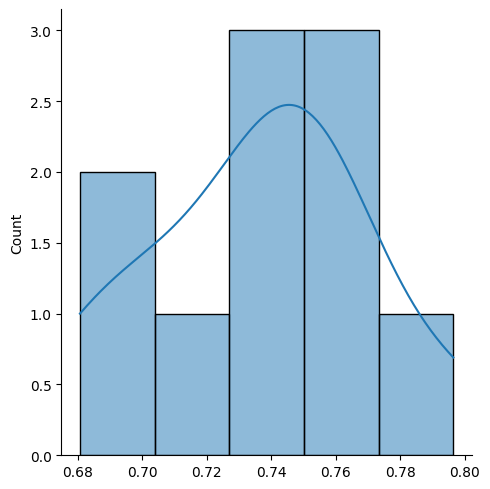

In [428]:
# k-fold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed,cv=kfold, scoring='r2' )
sns.displot(scores, kde=True)
plt.show()

In [429]:
print("Validation Score : \n Mean =", round(scores.mean(),3), "STD =", round(scores.std(),3), "\n",
      "Max  =", round(scores.max(), 3), "Min =", round(scores.min(),3))

Validation Score : 
 Mean = 0.736 STD = 0.032 
 Max  = 0.796 Min = 0.681


Try to get MAE (Mean Absolute Error) in this model.

In [430]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', LinearRegression())])

In [431]:
y_pred = pipeline.predict(X_test)
# mae = mean_absolute_error(y_test, y_pred)
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))
mae

0.9463822160089357

# Run multiple algorithm based models and see their Score and MAE
Make a function which accepts model name and returns these two scores

In [432]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output

In [433]:
model_dict = {
    'linerar_reg': LinearRegression(),
    'svr': SVR(),
    'ridge': Ridge(),
    'LASSO': Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest': RandomForestRegressor(),
    'extra tree': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost': XGBRegressor()
}

In [434]:
model_output = []
for model_name, model in model_dict.items():
    model_output.append(scorer(model_name, model))

matrics = pd.DataFrame(model_output, columns=['model', 'r2_score', 'mae'])
matrics.sort_values(by='mae')

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,r2_score,mae
10,xgboost,0.891701,0.511324
5,random forest,0.881537,0.537158
6,extra tree,0.867722,0.548438
7,gradient boosting,0.872621,0.576528
9,mlp,0.811052,0.696730
4,decision tree,0.773039,0.767395
8,adaboost,0.759255,0.798427
1,svr,0.764202,0.847264
2,ridge,0.736313,0.946339
0,linerar_reg,0.736310,0.946382


Test new startegy with 3 features with OHE - ['sector', 'agePossession', 'furnishing_type']

In [436]:
# columns to encode (categorical columns)
columns_to_encode_Ord = ['property_type', 'balcony', 'luxury_category', 'floor_category']
columns_to_encodeOHE = ['sector', 'agePossession', 'furnishing_type']
columns_to_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']

preprocessor = ColumnTransformer(
  transformers = [
   ('num', StandardScaler(), columns_to_scale),
   ('cat1', OrdinalEncoder(), columns_to_encode_Ord),
   ('cat2', OneHotEncoder(drop='first'), columns_to_encodeOHE)
  ],remainder='passthrough'
)

In [437]:
#create a pipeline using this preprocessor and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# k-fold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2' )

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

print(" Score Mean = ", scores.mean(), "\n", "Score STD = ", scores.std(), "\n", "Model MAE = ", mae)

 Score Mean =  0.854615702298591 
 Score STD =  0.015992342195195786 
 Model MAE =  0.6496719932511692


Check all the models on new strategy of applying OneHotEncoding to some features

In [438]:
model_output = []
for model_name, model in model_dict.items():
    model_output.append(scorer(model_name, model))

matrics = pd.DataFrame(model_output, columns=['model', 'r2_score', 'mae'])
matrics.sort_values(by='mae')

,model,r2_score,mae
6,extra tree,0.885355,0.477680
10,xgboost,0.892370,0.503674
9,mlp,0.882263,0.505959
1,svr,0.882774,0.533683
5,random forest,0.870567,0.536422
7,gradient boosting,0.856448,0.602104
4,decision tree,0.793638,0.629878
0,linerar_reg,0.854616,0.649672
2,ridge,0.854915,0.653729
8,adaboost,0.721731,0.874405


OneHotEncoding with PCA

In [445]:
# columns to encode (categorical columns)
columns_to_encode_Ord = ['property_type', 'balcony', 'luxury_category', 'floor_category']
columns_to_encodeOHE = ['sector', 'agePossession', 'furnishing_type']
columns_to_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']


# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
  transformers = [
   ('num', StandardScaler(), columns_to_scale),
   ('cat1', OrdinalEncoder(), columns_to_encode_Ord),
   ('cat2', OneHotEncoder(drop='first',sparse_output=False), columns_to_encodeOHE)
  ],remainder='passthrough'
)

# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('regression', LinearRegression())
])

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed,cv=kfold, scoring='r2' )

#print(scores.mean(), scores.std())
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

print(" Score Mean = ", scores.mean(), "\n", "Score STD = ", scores.std(), "\n", "Model MAE = ", mae)

 Score Mean =  0.7644414727636658 
 Score STD =  0.028840370479173618 
 Model MAE =  0.9061825500645798


In [446]:
# columns to encode (categorical columns)
columns_to_encode_Ord = ['property_type', 'balcony', 'luxury_category', 'floor_category']
columns_to_encodeOHE = ['sector', 'agePossession', 'furnishing_type']
columns_to_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']


# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
  transformers = [
   ('num', StandardScaler(), columns_to_scale),
   ('cat1', OrdinalEncoder(), columns_to_encode_Ord),
   ('cat2', OneHotEncoder(drop='first',sparse_output=False), columns_to_encodeOHE)
  ],remainder='passthrough'
)
    

def scorer(model_name, model):

    output = []
    output.append(model_name)
    
    #create a pipeline using this preprocessor and model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.95)),
        ('regressor', model)
    ])

    # k-fold cross validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2' )
    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

    output.append(mae)

    return output

model_output = []
for model_name, model in model_dict.items():
    model_output.append(scorer(model_name, model))

matrics = pd.DataFrame(model_output, columns=['model', 'r2_score', 'mae'])
matrics.sort_values(by='mae')

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv

,model,r2_score,mae
6,extra tree,0.839684,0.594826
5,random forest,0.820492,0.638745
10,xgboost,0.824887,0.652724
1,svr,0.823528,0.664194
9,mlp,0.818917,0.684729
7,gradient boosting,0.823669,0.694301
4,decision tree,0.623741,0.819411
0,linerar_reg,0.764441,0.906183
2,ridge,0.764486,0.906239
8,adaboost,0.690633,0.910837


PCA messedup the whole thing. Not a suitable algorithm even for 95% explainability of std.

# Target Encoding

Check for LinearRegression while Target Encoding is added for 'sector' column

In [451]:
# columns to encode (categorical columns)
columns_to_encode_Ord = ['property_type', 'balcony', 'luxury_category', 'floor_category']
columns_to_encodeOHE = ['agePossession', 'furnishing_type']
columns_to_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']


# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
  transformers = [
   ('num', StandardScaler(), columns_to_scale),
   ('cat1', OrdinalEncoder(), columns_to_encode_Ord),
   ('cat2', OneHotEncoder(drop='first',sparse_output=False), columns_to_encodeOHE),
   ('target', ce.TargetEncoder(), ['sector'])
  ],remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed,cv=kfold, scoring='r2' )

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

print(" Score Mean = ", scores.mean(), "\n", "Score STD = ", scores.std(), "\n", "Model MAE = ", mae)

 Score Mean =  0.828976628370946 
 Score STD =  0.018936274205272774 
 Model MAE =  0.7127278833922408


Target Encoding alongwith OneHotEncoder, OrdinalEncoder, StandardScalar.
Check for all 11 algorithms/model types 

In [457]:
# columns to encode (categorical columns)
columns_to_encode_Ord = ['property_type', 'balcony', 'luxury_category', 'floor_category']
columns_to_encodeOHE = ['agePossession', 'furnishing_type']
columns_to_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']
column_to_target = ['sector']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
  transformers = [
   ('target', ce.TargetEncoder(), column_to_target),
   ('num', StandardScaler(), columns_to_scale),
   ('cat1', OrdinalEncoder(), columns_to_encode_Ord),
   ('cat2', OneHotEncoder(drop='first',sparse_output=False), columns_to_encodeOHE),
  ],remainder='passthrough'
)

def scorer(model_name, model):

    output = []
    output.append(model_name)
    
    #create a pipeline using this preprocessor and model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # k-fold cross validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2' )
    output.append(scores.mean())

    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))

    output.append(mae)

    return output

model_output = []
for model_name, model in model_dict.items():
    model_output.append(scorer(model_name, model))

matrics = pd.DataFrame(model_output, columns=['model', 'r2_score', 'mae'])
matrics.sort_values(by='mae')

,model,r2_score,mae
5,random forest,0.893991,0.468424
6,extra tree,0.893289,0.473730
10,xgboost,0.900439,0.482847
7,gradient boosting,0.883556,0.526344
4,decision tree,0.815894,0.559555
1,svr,0.863047,0.584449
9,mlp,0.848601,0.606782
8,adaboost,0.813812,0.691883
0,linerar_reg,0.828977,0.712728
2,ridge,0.828992,0.713246


# Conclusion:
OrdinalEncoding = ['property_type', 'balcony', 'luxury_category', 'floor_category']             
OneHotEncoding = ['agePossession', 'furnishing_type']               
StandardScaler = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']             
TargetEncoding = ['sector']             

With the above encoding, RandomForest gives the best results.
We can go for Hyperparameter tuninng for this RandomForest algorithm.

# Hyperparameter Tuning
RandomForestRegressor

In [461]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__max_samples':[0.1, 0.25, 0.5, 1.0],
    'regressor__max_features': ['auto', 'sqrt']
}


# Creating a column transformer for encoding
columns_to_encode_Ord = ['property_type', 'balcony', 'luxury_category', 'floor_category']
columns_to_encodeOHE = ['agePossession', 'furnishing_type']
columns_to_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']
column_to_target = ['sector']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
  transformers = [
   ('target', ce.TargetEncoder(), column_to_target),
   ('num', StandardScaler(), columns_to_scale),
   ('cat1', OrdinalEncoder(), columns_to_encode_Ord),
   ('cat2', OneHotEncoder(drop='first',sparse_output=False), columns_to_encodeOHE),
  ],remainder='passthrough'
) 

#create a pipeline using this preprocessor and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# k-fold cross validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
# GridSearch CV for hyperparameter tuning
search = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring='r2', n_jobs=-1, verbose=4)
search.fit(X, y_transformed)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.878 total time=   0.4s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.901 total time=   0.4s
[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.890 total time=   0.4s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.888 total time=   0.4s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.858 total time=   0.4s
[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.869 total time=   0.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.877 total time=   0.5s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.871 total time=   0.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.842 total time=   0.6s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.864 total time=   0.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.881 total time=   1.0s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.904 total time=   0.9s
[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.898 total time=   0.9s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.881 total time=   0.9s
[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.869 total time=   0.9s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.864 total time=   0.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.870 total time=   0.7s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.876 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.852 total time=   0.9s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.869 total time=   0.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.884 total time=   1.5s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.908 total time=   1.5s
[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.897 total time=   1.5s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.880 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.873 total time=   1.5s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.867 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.877 total time=   1.6s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.875 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.849 total time=   1.5s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.865 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.884 total time=   2.2s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.906 total time=   2.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.896 total time=   2.4s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.884 total time=   2.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.867 total time=   2.3s
[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.875 total time=   2.4s
[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.882 total time=   0.8s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.916 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.907 total time=   0.5s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.894 total time=   0.5s
[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.874 total time=   2.3s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.875 total time=   2.3s
[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.887 total time=   0.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.868 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.886 total time=   0.8s
[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.864 total time=   0.8s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.880 total time=   0.9s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.870 total time=   0.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.846 total time=   2.7s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.865 total time=   2.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.888 total time=   1.4s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.917 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.907 total time=   1.2s
[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.890 total time=   1.2s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.899 total time=   1.2s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.875 total time=   1.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.883 total time=   1.2s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.883 total time=   1.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.863 total time=   1.4s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.872 total time=   1.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.893 total time=   2.3s
[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.910 total time=   2.3s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.919 total time=   2.4s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.897 total time=   2.3s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.872 total time=   2.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.889 total time=   2.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.887 total time=   2.2s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.885 total time=   2.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.858 total time=   1.9s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.875 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.890 total time=   2.8s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.918 total time=   2.8s
[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.910 total time=   2.7s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.897 total time=   2.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.890 total time=   2.6s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.876 total time=   2.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.892 total time=   0.7s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.921 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.914 total time=   0.7s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.900 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.896 total time=   0.7s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.873 total time=   0.7s
[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.885 total time=   2.6s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.882 total time=   2.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.891 total time=   0.8s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.887 total time=   0.8s
[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.868 total time=   0.8s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.875 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.876 total time=   2.6s
[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.860 total time=   2.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.897 total time=   1.4s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.925 total time=   1.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.917 total time=   1.4s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.901 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.901 total time=   1.5s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.876 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.887 total time=   1.5s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.884 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.867 total time=   1.5s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.877 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.895 total time=   2.7s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.925 total time=   2.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.920 total time=   2.6s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.902 total time=   2.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.897 total time=   2.6s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.877 total time=   2.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.889 total time=   2.6s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.884 total time=   2.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.867 total time=   2.6s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.877 total time=   2.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.896 total time=   3.8s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.925 total time=   3.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.916 total time=   3.8s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.900 total time=   3.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.898 total time=   3.8s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.879 total time=   3.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.891 total time=   1.0s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.927 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.920 total time=   1.0s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.898 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.890 total time=   3.9s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.883 total time=   3.9s
[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.902 total time=   1.0s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.878 total time=   1.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.880 total time=   1.1s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.881 total time=   1.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.878 total time=   1.0s
[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.864 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.865 total time=   4.0s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.880 total time=   3.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.895 total time=   1.9s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.924 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.922 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.902 total time=   2.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.877 total time=   1.9s
[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.901 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.882 total time=   1.9s
[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.882 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.866 total time=   1.9s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.879 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.897 total time=   3.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.930 total time=   3.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.922 total time=   3.7s
[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.900 total time=   3.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.902 total time=   3.8s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.879 total time=   3.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.885 total time=   3.7s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.882 total time=   3.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.867 total time=   3.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.881 total time=   3.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.928 total time=   6.0s
[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.894 total time=   6.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.900 total time=   6.0s
[CV 3/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.922 total time=   6.2s
[CV 1/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.880 total time=   0.3s
[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.903 total time=   6.0s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.879 total time=   6.1s
[CV 2/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.887 total time=   0.3s
[CV 3/10] END regressor__max_depth=None, r

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 6/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.883 total time=   2.7s
[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.879 total time=   0.4s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.903 total time=   0.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.893 total time=   0.5s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.880 total time=   0.5s
[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.876 total time=   0.5s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.864 total time=   0.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.873 total time=   0.4s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.878 total time=   0.4s
[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.844 total time=   0.4s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.858 total time=   0.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.897 total time=   3.2s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.888 total time=   3.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.881 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.902 total time=   0.7s
[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.896 total time=   0.8s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.882 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.861 total time=   0.8s
[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.873 total time=   0.8s
[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.877 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.872 total time=   0.8s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.866 total time=   0.7s
[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.844 total time=   0.8s
[CV 9/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.876 total time=   3.5s
[CV 10/10] END regressor__max_depth=None, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.874 total time=   3.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.885 total time=   1.3s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.905 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.894 total time=   1.3s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.863 total time=   1.3s
[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.871 total time=   1.3s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.883 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.877 total time=   1.4s
[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.874 total time=   1.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.846 total time=   1.3s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.864 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.884 total time=   1.8s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.906 total time=   1.8s
[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.897 total time=   1.8s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.881 total time=   1.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.864 total time=   1.7s
[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.875 total time=   1.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.889 total time=   0.5s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.914 total time=   0.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.891 total time=   0.6s
[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.906 total time=   0.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.874 total time=   2.0s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.875 total time=   2.0s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.868 total time=   0.8s
[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.888 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.880 total time=   0.7s
[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.882 total time=   0.7s
[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.860 total time=   0.5s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.871 total time=   0.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.847 total time=   2.2s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.866 total time=   2.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.889 total time=   1.0s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.914 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.893 total time=   1.0s
[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.906 total time=   1.0s
[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.886 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.870 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.884 total time=   1.1s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.881 total time=   1.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.854 total time=   1.1s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.870 total time=   1.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.916 total time=   1.9s
[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.886 total time=   1.9s
[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.907 total time=   1.9s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.895 total time=   1.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.886 total time=   1.8s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.871 total time=   1.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.885 total time=   1.8s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.882 total time=   1.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.858 total time=   1.6s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.873 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.889 total time=   2.4s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.916 total time=   2.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.908 total time=   2.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.894 total time=   2.4s
[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.888 total time=   2.3s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.873 total time=   2.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.890 total time=   0.7s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.920 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.917 total time=   0.7s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.897 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.884 total time=   2.5s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.881 total time=   2.6s
[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.889 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.872 total time=   0.8s
[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.886 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.883 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.863 total time=   0.7s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.875 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.860 total time=   2.9s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.871 total time=   2.9s
[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.887 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.917 total time=   1.4s
[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.916 total time=   1.4s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.897 total time=   1.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.892 total time=   1.4s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.876 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.888 total time=   1.3s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.882 total time=   1.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.862 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.875 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.893 total time=   2.2s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.921 total time=   2.2s
[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.915 total time=   2.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.899 total time=   2.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.891 total time=   2.3s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.874 total time=   2.3s
[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.888 total time=   2.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.882 total time=   2.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.864 total time=   2.3s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.876 total time=   2.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.890 total time=   3.2s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.920 total time=   3.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.915 total time=   3.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.894 total time=   3.1s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.898 total time=   3.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.874 total time=   3.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.887 total time=   1.0s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.920 total time=   1.0s
[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.913 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.893 total time=   1.0s
[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.893 total time=   0.8s
[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.887 total time=   3.4s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.882 total time=   3.4s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.872 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.881 total time=   0.8s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.877 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.874 total time=   0.8s
[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.860 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.863 total time=   3.4s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.877 total time=   3.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.893 total time=   1.4s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.921 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.919 total time=   1.5s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.898 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.894 total time=   1.6s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.872 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.882 total time=   1.6s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.875 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.863 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.875 total time=   1.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.891 total time=   3.0s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.920 total time=   2.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.920 total time=   2.9s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.896 total time=   2.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.896 total time=   2.9s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.872 total time=   2.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.883 total time=   2.9s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.877 total time=   3.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.859 total time=   2.9s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.876 total time=   2.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.921 total time=   4.1s
[CV 1/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.892 total time=   4.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.917 total time=   4.1s
[CV 4/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.897 total time=   4.3s
[CV 5/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.896 total time=   4.2s
[CV 1/10] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.883 total time=   0.4s
[CV 2/10] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.890 total time=   0.3s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.872 total time=   4.1s
[CV 3/10] END regressor__max_depth=10, regressor__max_

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.883 total time=   2.0s
[CV 6/10] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.874 total time=   2.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.877 total time=   0.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.905 total time=   0.6s
[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.889 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.881 total time=   0.7s
[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.866 total time=   0.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.861 total time=   0.5s
[CV 7/10] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.893 total time=   2.4s
[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.880 total time=   0.4s
[CV 8/10] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.883 total time=   2.4s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.874 total time=   0.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.834 total time=   0.5s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.866 total time=   0.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.882 total time=   0.8s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.905 total time=   0.8s
[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.895 total time=   0.8s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.879 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.871 total time=   0.8s
[CV 9/10] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.869 total time=   2.7s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.865 total time=   0.8s
[CV 10/10] END regressor__max_depth=10, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.867 total time=   2.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.876 total time=   0.8s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.871 total time=   0.8s
[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.841 total time=   0.8s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.868 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.887 total time=   1.5s
[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.895 total time=   1.4s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.883 total time=   1.4s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.906 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.876 total time=   1.4s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.866 total time=   1.4s
[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.875 total time=   1.4s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.872 total time=   1.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.847 total time=   1.4s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.868 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.881 total time=   2.0s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.906 total time=   2.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.895 total time=   2.0s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.884 total time=   2.0s
[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.876 total time=   2.0s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.862 total time=   2.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.888 total time=   0.6s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.919 total time=   0.6s
[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.907 total time=   0.6s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.895 total time=   0.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.878 total time=   2.1s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.874 total time=   2.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.889 total time=   0.7s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.873 total time=   0.7s
[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.884 total time=   0.7s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.878 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.863 total time=   0.7s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.872 total time=   0.7s
[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.846 total time=   2.2s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.866 total time=   2.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.919 total time=   1.1s
[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.907 total time=   1.1s
[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.893 total time=   1.2s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.899 total time=   1.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.890 total time=   1.0s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.871 total time=   1.0s
[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.886 total time=   1.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.884 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.863 total time=   1.1s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.874 total time=   1.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.888 total time=   2.1s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.919 total time=   2.1s
[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.909 total time=   2.0s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.895 total time=   2.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.887 total time=   2.1s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.871 total time=   2.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.885 total time=   1.9s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.884 total time=   2.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.873 total time=   1.9s
[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.859 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.889 total time=   2.7s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.918 total time=   2.7s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.897 total time=   2.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.910 total time=   2.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.890 total time=   2.7s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.874 total time=   2.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.898 total time=   0.9s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.925 total time=   0.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.919 total time=   0.9s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.900 total time=   0.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.887 total time=   2.8s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.884 total time=   2.8s
[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.897 total time=   0.7s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.874 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.883 total time=   0.8s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.886 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.864 total time=   0.9s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.881 total time=   0.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.859 total time=   3.1s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.873 total time=   3.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.897 total time=   1.6s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.923 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.919 total time=   1.6s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.901 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.897 total time=   1.7s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.880 total time=   1.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.887 total time=   1.6s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.888 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.862 total time=   1.7s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.878 total time=   1.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.897 total time=   2.9s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.926 total time=   2.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.919 total time=   2.9s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.901 total time=   2.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.897 total time=   3.1s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.876 total time=   3.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.891 total time=   3.0s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.885 total time=   3.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.863 total time=   2.9s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.880 total time=   3.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.895 total time=   4.2s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.926 total time=   4.2s
[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.918 total time=   3.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.901 total time=   4.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.899 total time=   4.2s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.879 total time=   4.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.893 total time=   1.3s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.926 total time=   1.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.920 total time=   1.2s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.902 total time=   1.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.901 total time=   1.2s
[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.890 total time=   4.3s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.877 total time=   1.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.884 total time=   4.4s
[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.878 total time=   1.1s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.881 total time=   1.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.862 total time=   1.2s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.880 total time=   1.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.867 total time=   4.5s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.880 total time=   4.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.896 total time=   2.2s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.928 total time=   2.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.898 total time=   2.1s
[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.919 total time=   2.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.897 total time=   2.2s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.876 total time=   2.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.886 total time=   2.2s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.880 total time=   2.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.864 total time=   2.2s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.881 total time=   2.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.898 total time=   4.0s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.927 total time=   4.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.922 total time=   4.0s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.899 total time=   4.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.904 total time=   4.0s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.876 total time=   4.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.882 total time=   4.0s
[CV 8/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.880 total time=   4.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.864 total time=   4.0s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.881 total time=   4.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.896 total time=   5.8s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.929 total time=   5.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.922 total time=   5.8s
[CV 4/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.899 total time=   5.8s
[CV 1/10] END regressor__max_depth=20, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.887 total time=   0.3s
[CV 2/10] END regressor__max_depth=20, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.886 total time=   0.3s
[CV 5/10] END regressor__max_depth=20, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.903 total time=   5.8s
[CV 3/10] END regressor__max_depth=20, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.868 total time=   0.3s
[CV 6/10] END regressor__max_depth=20, regressor__max_f

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=20, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.893 total time=   2.7s
[CV 6/10] END regressor__max_depth=20, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.881 total time=   2.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.882 total time=   0.4s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.901 total time=   0.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.894 total time=   0.6s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.880 total time=   0.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.872 total time=   0.7s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.861 total time=   0.6s
[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.876 total time=   0.6s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.871 total time=   0.5s
[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.835 total time=   0.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.864 total time=   0.5s
[CV 7/10] END regressor__max_depth=20, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.895 total time=   3.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10] END regressor__max_depth=20, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.890 total time=   3.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.883 total time=   0.8s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.902 total time=   0.8s
[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.890 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.884 total time=   1.0s
[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.870 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.863 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.870 total time=   1.0s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.873 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.852 total time=   1.0s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=100;, score=0.862 total time=   0.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=20, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.878 total time=   4.0s
[CV 10/10] END regressor__max_depth=20, regressor__max_features=sqrt, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.872 total time=   4.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.883 total time=   1.6s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.906 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.896 total time=   1.6s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.881 total time=   1.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.875 total time=   1.6s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.864 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.874 total time=   1.6s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.875 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.845 total time=   1.6s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=200;, score=0.864 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.884 total time=   2.1s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.905 total time=   2.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.895 total time=   2.1s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.882 total time=   2.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.876 total time=   2.1s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.863 total time=   2.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.891 total time=   0.7s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.919 total time=   0.7s
[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.909 total time=   0.7s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.893 total time=   0.6s
[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.878 total time=   2.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.875 total time=   2.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.887 total time=   0.6s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.872 total time=   0.7s
[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.885 total time=   0.6s
[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.854 total time=   0.6s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.879 total time=   0.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=50;, score=0.878 total time=   0.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.848 total time=   2.3s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=300;, score=0.866 total time=   2.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.887 total time=   1.3s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.915 total time=   1.3s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.894 total time=   1.3s
[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.891 total time=   1.3s
[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.909 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.871 total time=   1.3s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.886 total time=   1.2s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.884 total time=   1.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.859 total time=   1.1s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=100;, score=0.875 total time=   1.1s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.910 total time=   2.0s
[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.891 total time=   2.0s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.917 total time=   2.0s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.896 total time=   2.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.890 total time=   1.9s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.873 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.886 total time=   1.9s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.884 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.862 total time=   1.9s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=200;, score=0.874 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.892 total time=   2.7s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.918 total time=   2.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.910 total time=   2.8s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.897 total time=   2.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.871 total time=   2.9s
[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.888 total time=   2.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.896 total time=   0.9s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.923 total time=   0.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.914 total time=   0.9s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.896 total time=   0.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.898 total time=   0.9s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.884 total time=   3.1s
[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.888 total time=   3.1s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.882 total time=   0.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.892 total time=   0.9s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.884 total time=   0.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.862 total time=   0.8s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=50;, score=0.880 total time=   0.8s
[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.862 total time=   3.2s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.25, regressor__n_estimators=300;, score=0.873 total time=   3.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.894 total time=   1.8s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.925 total time=   1.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.914 total time=   1.7s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.902 total time=   1.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.895 total time=   1.8s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.875 total time=   1.8s
[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.885 total time=   1.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.884 total time=   1.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.868 total time=   1.6s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=100;, score=0.879 total time=   1.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.895 total time=   3.1s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.926 total time=   3.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.919 total time=   3.1s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.901 total time=   3.0s
[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.897 total time=   3.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.876 total time=   3.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.888 total time=   2.9s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.886 total time=   3.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.866 total time=   2.7s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=200;, score=0.880 total time=   2.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.896 total time=   4.4s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.926 total time=   4.5s
[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.919 total time=   4.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0`

[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.901 total time=   4.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.898 total time=   4.5s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.878 total time=   4.4s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.890 total time=   1.1s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.925 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.915 total time=   1.1s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.894 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.902 total time=   1.0s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.876 total time=   1.0s
[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.890 total time=   4.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.884 total time=   4.5s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.882 total time=   1.0s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.876 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.869 total time=   1.0s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=50;, score=0.882 total time=   1.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.865 total time=   4.0s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=0.5, regressor__n_estimators=300;, score=0.878 total time=   4.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.896 total time=   1.9s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.928 total time=   2.0s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.920 total time=   2.0s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.900 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.899 total time=   1.9s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.878 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.884 total time=   1.9s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.881 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.871 total time=   1.9s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=100;, score=0.882 total time=   1.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.897 total time=   3.8s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.928 total time=   3.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.921 total time=   3.8s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.898 total time=   3.8s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.902 total time=   3.8s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.878 total time=   3.9s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 7/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.885 total time=   3.7s
[CV 8/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.882 total time=   3.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 9/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.868 total time=   3.7s
[CV 10/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=200;, score=0.882 total time=   3.7s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.898 total time=   5.6s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.929 total time=   5.6s


/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.921 total time=   5.6s
[CV 4/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.901 total time=   5.6s
[CV 1/10] END regressor__max_depth=30, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.879 total time=   0.3s
[CV 5/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.904 total time=   5.6s
[CV 2/10] END regressor__max_depth=30, regressor__max_features=sqrt, regressor__max_samples=0.1, regressor__n_estimators=50;, score=0.889 total time=   0.3s
[CV 6/10] END regressor__max_depth=30, regressor__max_features=auto, regressor__max_samples=1.0, regressor__n_estimators=300;, score=0.877 total time=   5.7s
[CV 3/10] END regressor__max_depth=30, regressor__max_

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('target',
                                                                         TargetEncoder(),
                                                                         ['sector']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['bedRoom',
                                                                          'bathroom',
                                                                          'built_up_area',
                                                                          'servant '
                                                                          'room',
                                                                          'store '
                                                                          'room']),
                                                                        ('cat1',
                                                                         OrdinalEncoder(),
                                                                         ['property_type',
                                                                          'balcony',
                                                                          'lux...
                                                                        ('cat2',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['agePossession',
                                                                          'furnishing_type'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['auto', 'sqrt'],
                         'regressor__max_samples': [0.1, 0.25, 0.5, 1.0],
                         'regressor__n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=4)

In [464]:
final_pipe = search.best_estimator_

In [465]:
search.best_params_

{'regressor__max_depth': 20,
 'regressor__max_features': 'auto',
 'regressor__max_samples': 1.0,
 'regressor__n_estimators': 300}

In [466]:
search.best_score_

0.8944590324143109

In [468]:
final_pipe.fit(X, y_transformed)

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target', TargetEncoder(),
                                                  ['sector']),
                                                 ('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat1', OrdinalEncoder(),
                                                  ['property_type', 'balcony',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat2',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession',
                                                   'furnishing_type'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, max_features='auto',
                                       max_samples=1.0, n_estimators=300))])

In [470]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

final_pipe.fit(X_train,y_train)
y_pred = final_pipe.predict(X_test)
y_pred = np.expm1(y_pred)

mae = mean_absolute_error(np.expm1(y_test),y_pred)
mae

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0.46420067754349936

# Exporting the model

In [474]:
# Create the optimum model so far

# Creating a column transformer for encoding
columns_to_encode_Ord = ['property_type', 'balcony', 'luxury_category', 'floor_category']
columns_to_encodeOHE = ['agePossession', 'furnishing_type']
columns_to_scale = ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']
column_to_target = ['sector']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
  transformers = [
   ('target', ce.TargetEncoder(), column_to_target),
   ('num', StandardScaler(), columns_to_scale),
   ('cat1', OrdinalEncoder(), columns_to_encode_Ord),
   ('cat2', OneHotEncoder(drop='first',sparse_output=False), columns_to_encodeOHE),
  ],remainder='passthrough'
) 

#create a pipeline using this preprocessor and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(max_depth = 20, max_features = 'auto', max_samples = 1.0, n_estimators = 300))
])

pipeline.fit(X, y_transformed)

/Users/vivektyagi/miniconda3/envs/envDS/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('target', TargetEncoder(),
                                                  ['sector']),
                                                 ('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat1', OrdinalEncoder(),
                                                  ['property_type', 'balcony',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat2',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession',
                                                   'furnishing_type'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=20, max_features='auto',
                                       max_samples=1.0, n_estimators=300))])

In [479]:
import pickle

with open('./pickle/pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [480]:
with open('./pickle/df.pkl', 'wb') as file:
    pickle.dump(X, file)

# Try prediction

In [497]:
X.iloc[0:3, 0:]

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor


In [498]:
import pickle

with open('./pickle/pipeline.pkl', 'rb') as file:
    model = pickle.load(file)

np.expm1(model.predict(X.iloc[0:3, 0:]))
# Actual values : np.expm1(y_transformed[0:3])
# [0.82, 0.95, 0.32]
# Predicted:
# [0.78150681, 0.95757116, 0.40166922]

array([0.78150681, 0.95757116, 0.40166922])

In [500]:
X.columns

Index(['property_type', 'sector', 'bedRoom', 'bathroom', 'balcony',
       'agePossession', 'built_up_area', 'servant room', 'store room',
       'furnishing_type', 'luxury_category', 'floor_category'],
      dtype='object')